# Data Science Series ep0 - Experimenting With Data!

## Initialization

In [120]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt

from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve

def plot_confusion_matrix(y_train, y_train_pred, title=None, tpr=False):
    conf_mx = confusion_matrix(y_train, y_train_pred)
    make_confusion_matrix(conf_mx, categories=bin_labels, cbar=False, percent=False, figsize=(5,5), title=title, tpr=tpr)

# https://github.com/DTrimarchi10/confusion_matrix
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          tpr=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          normalize=True):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}\n".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    if tpr:
        tpr = ["{0:.2%}".format(value) for value in (cf / cf.sum(axis=1, keepdims=True)).flatten()]
    else:
        tpr = blanks

    box_labels = [f"{v1}{v2}{v3}{v4}".strip() for v1, v2, v3, v4 in zip(group_labels,group_counts,group_percentages, tpr)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    if normalize:
        cf = cf / cf.sum(axis=1, keepdims=True)

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)

    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories,yticklabels=categories)
    
    plt.yticks(rotation=0)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

def plot_corr(df):
    corr = df.corr()

    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.show()


# See https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

## Dataset Loading

We are using this dataset from Kaggle: https://www.kaggle.com/datasets/himanshu007121/invoice-data

### Description
Wholesale invoice data extracted from some accounting system (SAP?) in CSV format.

Each record describes a document and has, among others, these pieces of information:
- the branch that issued the document
- customer information
- total amount
- due date
- payment date

### Geometry
- Shape (rows × cols): 50,000 × 19
- Size: 7.17 MB


In [84]:
df = pd.read_csv("./data/1829078.csv")

## Exploratory Data Analysis (EDA)

In [85]:
design_report = ProfileReport(df)
design_report.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


## Data Preparation

From EDA findings, we perform the following transformations.

1. `area_business` is a null-valued column, so we can drop it
2. `clear_date` contains null values corresponding to unpaid invoices (unlabeled) that we need to drop
3. `invoice_id` contains null values corresponding to non-invoice documents that we can drop
4. `isOpen` indicates invoices s.t. `clear_date` is null, so it becomes a constant after step (2) and can be dropped.
5. `posting_id` is constant and can be dropped
6. `document type` becomes a constant after step (3) and can be dropped
7. `doc_id` and `invoice_id` are redundant and unique to each invoice, so we drop them
8. `name_customer` is a string that we do not use in this example. However, further work (clustering) could be made to reconcile slightly names representing the same customer across different branches
9. dates are represented in three different formats and must be normalized and converted to the proper data type

In [86]:
# (1) drop null columns
df = df.drop(columns=['area_business'])

# (2, 3) drop rows with null values (clear_date | invoice_id)
df = df.dropna()

# (4, 5, 6) drop constant columns
df = df.drop(columns=['posting_id', 'isOpen', 'document type'])

# (7) drop redundant and unique columns
df = df.drop(columns=['doc_id', 'invoice_id'])

# (8) drop unused columns
df = df.drop(columns=['name_customer'])

# (9) date conversion of 'dd-MM-YYYY HH:mm' formatted columns
df['clear_date'] = pd.to_datetime(df['clear_date'], format='%d-%m-%Y %H:%M')

# (9) date conversion of 'dd-MM-YYYY' formatted columns
df['posting_date'] = pd.to_datetime(df['posting_date'], format='%d-%m-%Y')

# (9) date conversion of 'YYYYMMdd' formatted columns
df['document_create_date'] = pd.to_datetime(df['document_create_date'], format='%Y%m%d')
df['document_create_date.1'] = pd.to_datetime(df['document_create_date.1'], format='%Y%m%d')
df['baseline_create_date'] = pd.to_datetime(df['baseline_create_date'], format='%Y%m%d')
df['due_in_date'] = pd.to_datetime(df['due_in_date'], format='%Y%m%d')

## Feature Engineering

### Payment delay calculation

We want to build a multi-class classifier that is able to classify invoices into the following classes, according to the payment delay in days (`past_due_days`).

Class | Description
-|-
<=0 | paid on time or even before the due date (negative delay)
1-5 | paid within 1 and 5 days past the due date
6-15 | paid within 6 and 15 days past the due date
16-30 | paid within 16 and 30 days past the due date
31-60 | paid within 31 and 60 days past the due date
\>60 | paid in more than 60 days past the due date

Thus, we discretize `payment_due_days` into these six classes, deriving the new `delay_bin` feature.
We also calculate the payment term in days (`due_in_days`).

In [87]:
# Calculate payment term and delay (in days)
df['due_in_days'] = (df['due_in_date'] - df['baseline_create_date']).dt.days
df['past_due_days'] = (df['clear_date'] - df['due_in_date']).dt.days

# Discretize payment delay
bins = [0, 5, 15, 30, 60]
bin_labels = ['<=0', '1-5', '6-15', '16-30', '31-60', '> 60']

df['delay_bin'] = np.digitize(df['past_due_days'], bins, right=True)

<AxesSubplot:>

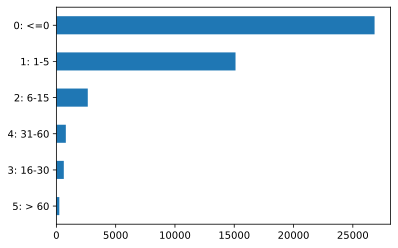

In [117]:
df['delay_bin'].map(lambda x: f'{x}: {bin_labels[x]}').value_counts()[::-1].plot.barh()

### Deriving features from dates

Here, we extract parts from datetime variables that are not suitable for ML algorithms into new features.

We only consider the following date variables.

Variable | Description
-|-
`baseline_create_date` | The baseline for due date calculation
`due_in_date` | Payment due date

We choas other dates are strictly correlated to `baseline_create_date`.

In [88]:
for col in ['baseline_create_date','due_in_date']:
    df[f'{col}.day'] = df[col].dt.day
    df[f'{col}.month'] = df[col].dt.month
    df[f'{col}.dayofweek'] = df[col].dt.dayofweek
    df[f'{col}.quarter'] = df[col].dt.quarter

### Currency conversion of CAD amounts to USD 

In order to be able to compare monetary amounts, we convert CAD to USD using the USD/CAD exchange rate of 0.79.

In [89]:
df.loc[df['invoice_currency'] == 'CAD', 'total_open_amount'] = df[df['invoice_currency'] == 'CAD']['total_open_amount'] * 0.79

### Calculating issued and paid invoices and amounts

For each invoice, we derive the following features based on the customer and date.

Metric | Description
-|-
`cust_td_invoices` | # of invoices issued to the customer up to the invoice date
`cust_td_invoices_cleared` | # of invoices issued to the customer that have been paid up to the invoice date
`cust_td_invoices_open` | `cust_td_invoices` - `cust_td_invoices_open`
`cust_td_amount` | cumulative invoiced amount of the customer at the invoice date
`cust_td_amount_cleared` | cumulative cleared amount of the customer at the invoice date
`cust_td_amount_open` | `cust_td_amount` - `cust_td_amount_cleared`

In [90]:
df_idx = df.set_index(['cust_number', 'baseline_create_date', 'clear_date']).sort_index()

def cust_invoices_stats(x: pd.Series):
    df_cust_issued_to_date = df_idx.loc[x['cust_number'], :x['baseline_create_date'], :]
    df_cust_cleared_to_date = df_idx.loc[x['cust_number'], :x['baseline_create_date'], :x['baseline_create_date']]

    return pd.Series({
        'cust_td_invoices':  df_cust_issued_to_date['total_open_amount'].count(),
        'cust_td_invoices_cleared': df_cust_cleared_to_date['total_open_amount'].count(),
        'cust_td_amount': df_cust_issued_to_date['total_open_amount'].sum(),
        'cust_td_amount_cleared': df_cust_cleared_to_date['total_open_amount'].sum()
    })

df_inv_count = df.apply(cust_invoices_stats, axis=1)

df = pd.concat([df, df_inv_count], axis=1)

df['cust_td_amount_open'] = df['cust_td_amount'] - df['cust_td_amount_cleared']
df['cust_td_invoices_open'] = df['cust_td_invoices'] - df['cust_td_invoices_cleared']

### Saving/Loading preprocessed data

When you are done with this first part of data preparation, you can save preprocessed data to be able to quickly restore it without reprocessing.

In [92]:
# save preprocessed data
df.to_pickle('./data/prep_dataset.pkl')

In [93]:
# load preprocessed data
df = pd.read_pickle("./data/prep_dataset.pkl")

### Further transformations

1. One-Hot encoding of categorial variables
2. remove all date variables (numerical features derived from `baseline_create_date` and `due_in_date` are retained)
3. log-transform monetary amounts to reduce distribution skeweness, which usually leads to performance improvements
4. separate input features (X) and output labels/targets (y)

In [94]:
df_data = df.copy()

# categorial variables
cat_cols = ['business_code', 'cust_payment_terms', 'invoice_currency', 'cust_number']

# (1) replace categorical vars with one-hot encoding
dfs_encoded_cat = [pd.get_dummies(df_data[c], c) for c in cat_cols]
df_data = pd.concat([df_data] + dfs_encoded_cat, axis=1)
df_data.drop(columns=cat_cols, inplace=True)

# (2) find and remove datetime variables
dt_cols = [k for k in df_data.dtypes.keys() if np.issubdtype(df_data.dtypes[k], np.datetime64)]
df_data.drop(columns=dt_cols, inplace=True)

# (3) log-transform monetary amounts
df_data['total_open_amount'] = np.log(1 + df_data['total_open_amount'])
df_data['cust_td_amount_open'] = np.log(1 + df_data['cust_td_amount_open'])
df_data['cust_td_amount_cleared'] = np.log(1 + df_data['cust_td_amount_cleared'])

# (4) separate variables that must be regarded as model output (classification or regression)
out_cols = set(['delay_bin', 'clear_date', 'past_due_days'])

# (4) input features
df_X = df_data.drop(columns = out_cols, errors='ignore')

# (4) labels/targets
df_y = df_data.drop(columns=df_X.columns)

## Model selection and training

### Making training and test sets

In [96]:
# numPy arrays for input features and labels (whole dataset)
X, y = df_X.values, df_y['delay_bin'].values.ravel()

# Split dataset into training set (70%) and a test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'Shape of the X input features matrix (rows x cols): {X.shape}')
print(f'        Shape of the y labels vector (rows x cols): {y.shape}')

Shape of the X input features matrix (rows x cols): (46261, 1192)
        Shape of the y labels vector (rows x cols): (46261,)


### Support Vector Machine (SVM)

https://en.wikipedia.org/wiki/Support-vector_machine

#### Model definition and training

In [118]:
from sklearn.svm import SVC

p_svm = Pipeline([
    ("scaler", StandardScaler()),
    ('clf', SVC())
]).fit(X_train, y_train)

#### Confusion matrix

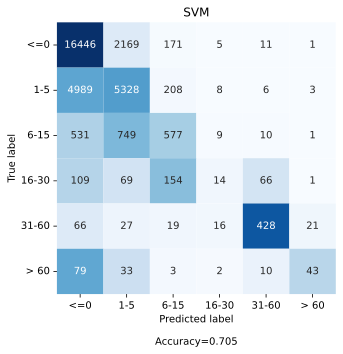

In [139]:
svm_y_train_pred = cross_val_predict(p_svm, X_train, y_train, cv=3)
plot_confusion_matrix(y_train, svm_y_train_pred, title='SVM')

#### Performance summary

In [142]:
print(classification_report(y_train, svm_y_train_pred, digits=3, target_names=bin_labels))

              precision    recall  f1-score   support

         <=0      0.740     0.875     0.802     18803
         1-5      0.636     0.505     0.563     10542
        6-15      0.510     0.307     0.384      1877
       16-30      0.259     0.034     0.060       413
       31-60      0.806     0.742     0.773       577
        > 60      0.614     0.253     0.358       170

    accuracy                          0.705     32382
   macro avg      0.594     0.453     0.490     32382
weighted avg      0.687     0.705     0.688     32382



### Random Forest

https://en.wikipedia.org/wiki/Random_forest

#### Model definition and training

In [97]:
from sklearn.ensemble import RandomForestClassifier

p_rf = Pipeline([
    ("scaler", StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
]).fit(X_train, y_train)

#### Confusion matrix

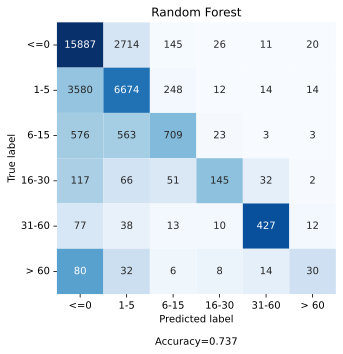

In [122]:
rf_y_train_pred = cross_val_predict(p_rf, X_train, y_train, cv=3)
plot_confusion_matrix(y_train, rf_y_train_pred, title='Random Forest')

#### Perfromance summary

In [113]:
rf_perf = pd.DataFrame(classification_report(y_train, rf_y_train_pred, digits=3, target_names=bin_labels, output_dict=True))
print(classification_report(y_train, rf_y_train_pred, digits=3, target_names=bin_labels))

              precision    recall  f1-score   support

         <=0      0.782     0.845     0.812     18803
         1-5      0.662     0.633     0.647     10542
        6-15      0.605     0.378     0.465      1877
       16-30      0.647     0.351     0.455       413
       31-60      0.852     0.740     0.792       577
        > 60      0.370     0.176     0.239       170

    accuracy                          0.737     32382
   macro avg      0.653     0.521     0.568     32382
weighted avg      0.730     0.737     0.730     32382



### Multi-Layer-Perceptron (MLP) Artificial Neural Network

https://en.wikipedia.org/wiki/Multilayer_perceptron

#### Model definition and training

In [138]:
from sklearn.neural_network import MLPClassifier

p_mlp = Pipeline([
    ("scaler", StandardScaler()),
    ('clf', MLPClassifier(random_state=42, max_iter=300, hidden_layer_sizes=(100,)))
]).fit(X_train, y_train)

#### Confusion matrix

/home/clinamen/work/personal/ds-01/src/classification/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


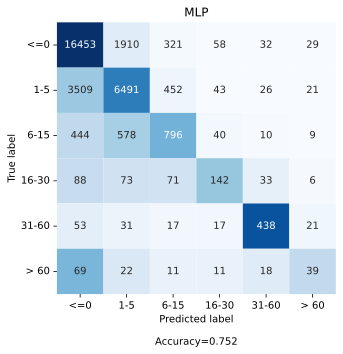

In [140]:
mlp_y_train_pred = cross_val_predict(p_mlp, X_train, y_train, cv=3)
plot_confusion_matrix(y_train, mlp_y_train_pred, title='MLP')

#### Performance summary

In [180]:
print(classification_report(y_train, mlp_y_train_pred, digits=3, target_names=bin_labels))

              precision    recall  f1-score   support

         <=0      0.798     0.875     0.835     18803
         1-5      0.713     0.616     0.661     10542
        6-15      0.477     0.424     0.449      1877
       16-30      0.457     0.344     0.392       413
       31-60      0.786     0.759     0.772       577
        > 60      0.312     0.229     0.264       170

    accuracy                          0.752     32382
   macro avg      0.591     0.541     0.562     32382
weighted avg      0.745     0.752     0.746     32382



### Find the best model

In [173]:
from sklearn.metrics import accuracy_score

candidades = [p_rf, p_svm, p_mlp]
model_names = ['Random Forest', 'SVM', 'MLP']
preds = [rf_y_train_pred, svm_y_train_pred, mlp_y_train_pred]

# calculate accuracy scores of all models
scores = np.array(list(map(lambda x: accuracy_score(y_train, x), preds)))

# select the model with higher accuracy
i_best_model = np.argmax(scores)
best_model = candidades[i_best_model]

# summary
pd.DataFrame(np.transpose([model_names, scores]), columns=['Model', 'Score'])

Model               Score
0  Random Forest  0.7371996788339201
1            SVM    0.70520659625718
2            MLP   0.752238898153295

## Evaluation

In [176]:
y_test_pred = best_model.predict(X_test)

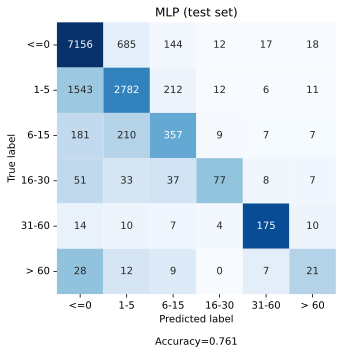

In [178]:
plot_confusion_matrix(y_test, y_test_pred, title=model_names[i_best_model] + ' (test set)')

In [181]:
print(classification_report(y_test, y_test_pred, digits=3, target_names=bin_labels))

              precision    recall  f1-score   support

         <=0      0.798     0.891     0.842      8032
         1-5      0.745     0.609     0.671      4566
        6-15      0.466     0.463     0.465       771
       16-30      0.675     0.362     0.471       213
       31-60      0.795     0.795     0.795       220
        > 60      0.284     0.273     0.278        77

    accuracy                          0.761     13879
   macro avg      0.627     0.565     0.587     13879
weighted avg      0.757     0.761     0.755     13879

